In [1]:
import pandas as pd 
import numpy as np
from nltk import WordPunctTokenizer
from nltk import TreebankWordTokenizer
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import chi2
from sklearn import svm
from sklearn.metrics import precision_score,recall_score,fbeta_score, precision_recall_fscore_support,confusion_matrix,accuracy_score
from sklearn.model_selection import KFold
from pprint import pprint
import os 
import time

In [2]:
# open dataset and preprocess
data = pd.read_csv('..\\sarcasm_dataset_clean.csv')          # import the data
labels = data['label'].tolist()                              # extracts the labels as a list 
labels = np.array(labels)
text = data['text'].tolist()                                 # extracts the text to be processed as a list

In [3]:
# tok = TreebankWordTokenizer()
# tokenizer=tok.tokenize, use this if the results are poor
minfreq = 3                                              # Used to prune those terms (uni-|bi-|tri- grams whose frequency is less than this)

In [4]:
print(text[0])

Do you remember me telling you we are practicing non-verbal spells, Potter?" "Yes," said Harry stiffly. "Yes, sir." "There's no need to call me "sir" Professor." The words had escaped him before he knew what he was saying.  '


In [5]:
def process_data(text,labels,n_gram,tokenizer=None,min_document_frequency=2,minfreq=3):
    '''
        Tokenizes the dataset and return the term-frequency matrix of the frequent n-grams 
        
        Parameters
        -----------
        text : list
            List of strings containing the text to be processed.
        labels: list
            List of labels
        n_gram: int
            The size of the n-gram to be returned
        tokenizer:
            String tokenizer to be used
        min_document_frequency: 
            The minimum document frequency to be used to prune n-grams
        minfreq: 
            The minimum frequency to be used to prune n-grams
            
        Returns
        -------
        dataframe : Pandas DataFrame
            The text converted as a term-frequency matrix
        n_grams : list
            The list of n-grams that were generated
        weights: tuple 
            p_value , chi2 value 
    '''
    vectorizer = CountVectorizer(tokenizer=tokenizer,lowercase=False,\
                                 ngram_range=(n_gram,n_gram),\
                                 min_df=min_document_frequency,\
                                 stop_words='english',\
                                 token_pattern='\\w+')
    
    processed_data = (vectorizer.fit_transform(text))                      
    processed_data = processed_data.toarray()                              
    
    n_grams = vectorizer.get_feature_names()                               
    
    counts = np.sum(processed_data,axis=0)                                 
    indices_to_keep = (np.argwhere(counts > minfreq)).flatten()            
    processed_data = processed_data[:,indices_to_keep] 
    n_grams = [n_grams[i]  for i in indices_to_keep]
    dataframe = pd.DataFrame(processed_data)
    
    weights = chi2(processed_data,labels)
    
    return dataframe,n_grams,weights

In [6]:
def store(file_name,data,labels):
#     <line> .=. <target> <feature>:<value> <feature>:<value> ... <feature>:<value> # <info>
#     <target> .=. {+1,-1}
#     <feature> .=. <integer>
#     <value> .=. <float>
#     <info> .=. <string>
    labels = 2*labels - 1
    with open(file_name+'.dat','w') as f :
        final_string = ""
        for idx,row in data.iterrows():
            string = ''
            string += '+1 ' if labels[idx] ==1 else '-1 '
            column_indices = data.columns
            for index in column_indices:
                if row[index] == 0:
                    continue
                string += str((index+1))+':'+str(row[index])+' '
            string += '\n'
            final_string += string
        f.write(final_string[:-1])
        print('Finished Storing')
        return final_string

In [7]:
unigrams_matrix,unigrams,(unigram_chi,unigram_p) = process_data(text,labels,1)
unigram_features = unigrams_matrix*unigram_chi
print(unigrams_matrix.shape)

(3756, 3469)


In [8]:
bigrams_matrix,bigrams,(bigram_chi,bigram_p) = process_data(text,labels,2)
bigram_features = bigrams_matrix*bigram_chi
print(bigrams_matrix.shape)

(3756, 594)


In [9]:
trigrams_matrix,trigrams,(trigram_chi,trigram_p) = process_data(text,labels,3)
trigram_features = trigrams_matrix*trigram_chi
print(trigrams_matrix.shape)
# print(trigrams)
# print(trigrams_matrix)

(3756, 63)


In [10]:
#final_string = store('train_data',trigrams_matrix,labels)

In [10]:
def shuffle(df):
    '''
        Shuffles pandas Dataframe
        
        Parameters
        -----------
        df : pd.DataFrame
            Dataframe to be shuffled
    
                
        Returns
        -------
        df_copy : Pandas DataFrame
            Shuffled Dataframe copy is returned    
    '''
    df_copy = df.copy()
    df_copy = df_copy.sample(frac=1).reset_index(drop=True)
    return df_copy

def customKfold(data, labels, n_folds=5, random_seed=99):
    # Note: Will not shuffle data - Shuffle before and pass
    '''
        Stores train and test .dat files for each fold
        
        Parameters
        -----------
        data : pd.DataFrame
            Feature vectors
        labels: list
            True Labels
        n_folds:
            Number of folds required
        random_seed: 
            Random seed to generate the split
    '''
    from sklearn.model_selection import KFold
    kfold = KFold(n_folds, True, random_seed)
    iteration = 1
    for train, test in kfold.split(data):
        print(iteration)
        X_train, X_test, y_train, y_test = np.array(data.iloc[train]), np.array(data.iloc[test]), labels[train], labels[test]
        X_train = pd.DataFrame(X_train)
        X_test = pd.DataFrame(X_test)
        store('data/train_'+str(iteration), X_train, y_train)
        store('data/test_'+str(iteration), X_test, y_test)
        iteration += 1

In [ ]:
lieb_f = pd.concat([unigram_features, bigram_features, trigram_features], axis = 1)
# lieb_f = unigram_features
customKfold(lieb_f,labels)

1
Finished Storing
Finished Storing
2
Finished Storing
Finished Storing
3
Finished Storing
Finished Storing
4
Finished Storing
Finished Storing
5


In [13]:
# start_time = time.time()
# features = shuffle(lieb_f)
features = lieb_f
# end_time = time.time()-start_time
# print(end_time)

In [ ]:
model = svm.SVC(gamma='auto',kernel='sigmoid', class_weight='balanced',C=20.0)
kfold = KFold(5,True,1)
p_scores = []
r_scores = []
f_scores = []
for train,test in kfold.split(features):
    X_train,X_test,y_train,y_test = features.iloc[train],features.iloc[test],labels[train],labels[test]
    print('start fitting')
    model.fit(X_train,y_train)
    print('finished fitting:\npredicting:')
    y_predict = model.predict(X_test)
    print('results:')
    p_temp = precision_score(y_test,y_predict)
    r_temp = recall_score(y_test,y_predict)
    f_temp = fbeta_score(y_test,y_predict,1)
    c_matrix = confusion_matrix(y_test,y_predict)
    print(precision_recall_fscore_support(y_test,y_predict))
    print(c_matrix)
    p_scores.append(p_temp)
    r_scores.append(r_temp)
    f_scores.append(f_temp)
    print(p_temp,r_temp,f_temp)

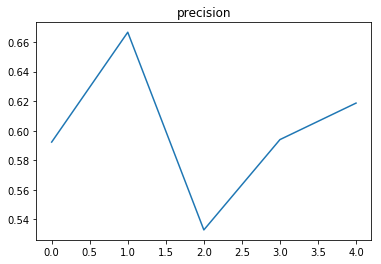

In [32]:
plt.title('precision')
plt.plot([x for x in range(len(p_scores))],[score for score in p_scores])
plt.show()

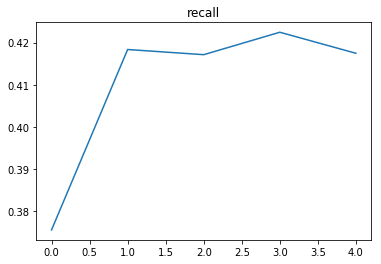

In [34]:
plt.title('recall')
plt.plot([x for x in range(len(r_scores))],[score for score in r_scores])
plt.show()

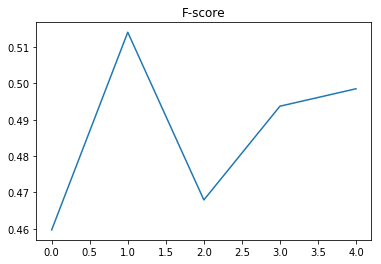

In [33]:
plt.title('F-score')
plt.plot([x for x in range(len(f_scores))],[score for score in f_scores])
plt.show()

In [36]:
f_scores = [score for score in f_scores]
mean = 0
for i in f_scores:
    mean+= i
print(mean/len(f_scores))
print(f_scores)
# confidence intervals
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower = max(0.0, np.percentile(f_scores, p))
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = min(1.0, np.percentile(f_scores, p))
print('%.1f confidence interval: %.1f and %.1f' % (alpha*100, lower*100, upper*100))

0.4868115036391626
[0.45970149253731346, 0.5141065830721003, 0.46794871794871795, 0.49375, 0.4985507246376812]
95.0 confidence interval: 46.1 and 51.3
